# **Time Series Forecasting with Neural Networks**

In this project we will using 2 different dataset to showcase 6 different types of Neural Network architectures, see how they perform for single/multi variable forecasting and make comparative conclusions.

## Stock Dataset Overview

Yahoo Finance Stock Data contains variety of stock prices across different investment platforms. Since we have to make a comparison between our NN models, I will use the NVIDIA stock dataset as our single-stock forecasting. And for the multi-stock forecasting models, I will take the 5 biggest worldwide company's stock prices and make the general stock model on their price changes. (Nvidia, Amazon, Apple, Microsoft and Google)

## Importing Libraries and Datasets

Before we start training different networks, let's first import the requirements

In [7]:
# Standard Libraries
import logging
import random
import warnings
from math import sqrt

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Preprocessing
import sklearn.metrics as metrics
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Concatenate, Conv1D, Dense, Dropout, Flatten, Input,
                                     LSTM, MaxPooling1D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Other Libraries
from neuralprophet import NeuralProphet
from scipy.spatial.distance import cosine

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


Now let's import and tidy up our datasets appropriately

In [9]:
nvda = pd.read_csv(r'C:\Users\user\Desktop\yahoo_NVDA.csv')
appl = pd.read_csv(r'C:\Users\user\Desktop\yahoo_AAPL.csv')
msft = pd.read_csv(r'C:\Users\user\Desktop\yahoo_MSFT.csv')
amzn = pd.read_csv(r'C:\Users\user\Desktop\yahoo_AMZN.csv')
goog = pd.read_csv(r'C:\Users\user\Desktop\yahoo_GOOG.csv')

In [10]:
nvda.head()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
0,0,NVDA,2016-07-27,56.060001,55.720001,11122600,57.119999,56.060001,57.220001
1,1,NVDA,2016-07-26,56.630001,56.090000,12862700,56.169998,56.630001,56.919998
2,2,NVDA,2016-07-25,55.680000,54.759998,7813200,55.000000,55.680000,55.810001
3,3,NVDA,2016-07-22,54.669998,53.020000,7894200,53.410000,54.669998,54.669998
4,4,NVDA,2016-07-21,53.220001,53.040001,9032700,54.099998,53.220001,54.270000


In [11]:
appl.head()

,Unnamed: 0,Symbol,Adj_Close,High,Low,Volume,Open,Date,Close
0,0,AAPL,102.949997,104.349998,102.750000,90898300,104.269997,2016-07-27,102.949997
1,1,AAPL,96.669998,97.970001,96.419998,42342400,96.820000,2016-07-26,96.669998
2,2,AAPL,97.339996,98.839996,96.919998,40144400,98.250000,2016-07-25,97.339996
3,3,AAPL,98.660004,99.300003,98.309998,28177200,99.260002,2016-07-22,98.660004
4,4,AAPL,99.430000,101.000000,99.129997,31792000,99.830002,2016-07-21,99.430000


In [12]:
msft.head()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
0,0,MSFT,2016-07-27,56.189999,56.110001,32095300,56.610001,56.189999,56.799999
1,1,MSFT,2016-07-26,56.759998,56.509998,27922600,56.520000,56.759998,57.290001
2,2,MSFT,2016-07-25,56.730000,56.259998,24260500,56.470001,56.730000,56.740002
3,3,MSFT,2016-07-22,56.570000,55.779999,31815500,56.080002,56.570000,56.630001
4,4,MSFT,2016-07-21,55.799999,55.759998,32600100,55.980000,55.799999,56.230000


In [13]:
amzn.head()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
0,0,AMZN,2016-07-27,736.669983,733.859985,2831800,737.969971,736.669983,740.940002
1,1,AMZN,2016-07-26,735.590027,732.750000,2481300,742.710022,735.590027,743.130005
2,2,AMZN,2016-07-25,739.609985,735.349976,2671000,746.549988,739.609985,748.500000
3,3,AMZN,2016-07-22,744.859985,743.530029,2253200,747.789978,744.859985,751.280029
4,4,AMZN,2016-07-21,744.429993,742.789978,2285100,747.500000,744.429993,749.359985


In [14]:
goog.head()

,Unnamed: 0,Symbol,Date,Close,Low,Volume,Open,Adj_Close,High
0,0,GOOG,2016-07-27,741.770020,737.000000,1497100,738.280029,741.770020,744.460022
1,1,GOOG,2016-07-26,738.419983,734.270020,1179400,739.039978,738.419983,741.690002
2,2,GOOG,2016-07-25,739.770020,737.500000,1030700,740.669983,739.770020,742.609985
3,3,GOOG,2016-07-22,742.739990,736.559998,1256300,741.859985,742.739990,743.239990
4,4,GOOG,2016-07-21,738.630005,735.830994,969100,740.359985,738.630005,741.690002


## EDA and Preprocessing

In [16]:
nvda = nvda.iloc[:, 2:]
nvda.head()

,Date,Close,Low,Volume,Open,Adj_Close,High
0,2016-07-27,56.060001,55.720001,11122600,57.119999,56.060001,57.220001
1,2016-07-26,56.630001,56.090000,12862700,56.169998,56.630001,56.919998
2,2016-07-25,55.680000,54.759998,7813200,55.000000,55.680000,55.810001
3,2016-07-22,54.669998,53.020000,7894200,53.410000,54.669998,54.669998
4,2016-07-21,53.220001,53.040001,9032700,54.099998,53.220001,54.270000


In [17]:
nvda.info()
appl.info()
msft.info()
amzn.info()
goog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Close      1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Volume     1258 non-null   int64  
 4   Open       1258 non-null   float64
 5   Adj_Close  1258 non-null   float64
 6   High       1258 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1258 non-null   int64  
 1   Symbol      1258 non-null   object 
 2   Adj_Close   1258 non-null   float64
 3   High        1258 non-null   float64
 4   Low         1258 non-null   float64
 5   Volume      1258 non-null   int64  
 6   Open        1258 non-null   floa

In [18]:
nvda['Date'] = pd.to_datetime(nvda['Date'])
print("\n NVDA Date range:", nvda['Date'].min(), "to", nvda['Date'].max())
appl['Date'] = pd.to_datetime(appl['Date'])
print("\n Apple Date range:", appl['Date'].min(), "to", appl['Date'].max())
msft['Date'] = pd.to_datetime(msft['Date'])
print("\n Microsoft Date range:", msft['Date'].min(), "to", msft['Date'].max())
amzn['Date'] = pd.to_datetime(amzn['Date'])
print("\n Amazon Date range:", amzn['Date'].min(), "to", amzn['Date'].max())
goog['Date'] = pd.to_datetime(goog['Date'])
print("\n Google Date range:", goog['Date'].min(), "to", goog['Date'].max())


 NVDA Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00

 Apple Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00

 Microsoft Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00

 Amazon Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00

 Google Date range: 2011-07-28 00:00:00 to 2016-07-27 00:00:00


In [19]:
print(nvda.isnull().sum())
print(appl.isnull().sum())
print(msft.isnull().sum())
print(amzn.isnull().sum())
print(goog.isnull().sum())

Date         0
Close        0
Low          0
Volume       0
Open         0
Adj_Close    0
High         0
dtype: int64
Unnamed: 0    0
Symbol        0
Adj_Close     0
High          0
Low           0
Volume        0
Open          0
Date          0
Close         0
dtype: int64
Unnamed: 0    0
Symbol        0
Date          0
Close         0
Low           0
Volume        0
Open          0
Adj_Close     0
High          0
dtype: int64
Unnamed: 0    0
Symbol        0
Date          0
Close         0
Low           0
Volume        0
Open          0
Adj_Close     0
High          0
dtype: int64
Unnamed: 0    0
Symbol        0
Date          0
Close         0
Low           0
Volume        0
Open          0
Adj_Close     0
High          0
dtype: int64


In [20]:
nvda = nvda.sort_values('Date')
date_range = pd.date_range(start=nvda['Date'].min(), end=nvda['Date'].max())
missing_dates = set(date_range) - set(nvda['Date'])
print(f"\nNumber of missing dates for NVDA: {len(missing_dates)}")
appl = appl.sort_values('Date')
date_range = pd.date_range(start=appl['Date'].min(), end=appl['Date'].max())
missing_dates = set(date_range) - set(appl['Date'])
print(f"\nNumber of missing dates for Apple: {len(missing_dates)}")
msft = msft.sort_values('Date')
date_range = pd.date_range(start=msft['Date'].min(), end=msft['Date'].max())
missing_dates = set(date_range) - set(msft['Date'])
print(f"\nNumber of missing dates for Microsoft: {len(missing_dates)}")
amzn = amzn.sort_values('Date')
date_range = pd.date_range(start=amzn['Date'].min(), end=amzn['Date'].max())
missing_dates = set(date_range) - set(amzn['Date'])
print(f"\nNumber of missing dates for Amazon: {len(missing_dates)}")
goog = goog.sort_values('Date')
date_range = pd.date_range(start=goog['Date'].min(), end=goog['Date'].max())
missing_dates = set(date_range) - set(goog['Date'])
print(f"\nNumber of missing dates for Google: {len(missing_dates)}")


Number of missing dates for NVDA: 569

Number of missing dates for Apple: 569

Number of missing dates for Microsoft: 569

Number of missing dates for Amazon: 569

Number of missing dates for Google: 569


Okay so, I did some repetetive things, but I had to make sure that all this separate stock price datasets had the same features and characteristics, so I did not mess up their merge. As it turns out all of this datasets are pretty identical, in terms of their structure, missing dates (which is exactly the same as it should be, because for the given interval the number of holidays, weekends and times where stock market is not active matches perfectly with our missing dates number) and date range.

Now I will merge them and get rid of the unnecessary columns and preprocess it properly for further model benchmarking processes

In [23]:
nvda = nvda[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "nvda"})
appl = appl[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "appl"})
msft = msft[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "msft"})
amzn = amzn[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "amzn"})
goog = goog[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "goog"})

all = nvda.merge(appl, on="Date", how="inner") \
                .merge(msft, on="Date", how="inner") \
                .merge(amzn, on="Date", how="inner") \
                .merge(goog, on="Date", how="inner")

all = all.sort_values(by="Date").reset_index(drop=True)

all.head()

,Date,nvda,appl,msft,amzn,goog
0,2011-07-28,12.914859,51.523488,24.110884,223.899994,305.165344
1,2011-07-29,12.914859,51.347280,23.832548,222.520004,301.543972
2,2011-08-01,13.605893,52.171771,23.719475,221.320007,303.082428
3,2011-08-02,13.465819,51.140829,23.310667,211.699997,295.904590
4,2011-08-03,13.830012,51.622111,23.415044,209.960007,300.285244


In [24]:
nvda.head()

,Date,nvda
1257,2011-07-28,12.914859
1256,2011-07-29,12.914859
1255,2011-08-01,13.605893
1254,2011-08-02,13.465819
1253,2011-08-03,13.830012


Here it is, our final datasets ready to be trained. df is for a general stock modeling and nvda is for a single stock price forecasting.

Now I have to choose which model to use for this task. Since the stock prices tend to be more noisy, non-stationary and highly volatile, I thinks the following models would suit them the best:

- LSTM, which is excellent for time-series with temporal dependencies
- 1D CNN, which can learn short-term patterns in stock movement
- Neural Prophet, which is build for forecasting with trend and seasonality, and also handles stocl-like data well

I will apply all this 3 to both, single stock and multiple stock datasets and let's see how can they perform

First let's start with a single stock nvda dataset and train all 3 models on it. And before we do that we have to do some preprocessing steps, to make both of these datasets ready for our different types of models, because they all need their specific approach and forms of dataset.

In [28]:
nvda['Date'] = pd.to_datetime(nvda['Date'])
all['Date'] = pd.to_datetime(all['Date'])

nvda = nvda.sort_values('Date').reset_index(drop=True)
all = all.sort_values('Date').reset_index(drop=True)

In [29]:
df = nvda.copy()
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

nvda_scaler = MinMaxScaler()
scaled_prices = nvda_scaler.fit_transform(df[['nvda']])

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_prices)):
    X.append(scaled_prices[i-lookback:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

split_index = int(len(X) * 0.8)
X_train_nvda, X_test_nvda = X[:split_index], X[split_index:]
y_train_nvda, y_test_nvda = y[:split_index], y[split_index:]

## Single-Stock Models Benchmarking and Evaluation

In [31]:
# LSTM for NVIDIA
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def cosine_similarity(y_true, y_pred):
    return 1 - cosine(y_true.flatten(), y_pred.flatten())

all_metrics = pd.DataFrame(columns=['Model', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])
BASE_SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def build_lstm_model(lookback):
    model = Sequential([
        Input(shape=(lookback, 1)),
        LSTM(64, activation='relu', return_sequences=True),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []

warnings.filterwarnings('ignore')

for i in range(5):
    print(f"\nRunning LSTM Model {i+1}/5")
    set_seed(BASE_SEED + i)

    model = build_lstm_model(X_train_nvda.shape[1])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_nvda, y_train_nvda,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    y_pred = model.predict(X_test_nvda)

    y_true_reshaped = y_test_nvda.reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)

    y_true_transform = np.zeros((len(y_true_reshaped), nvda_scaler.n_features_in_))
    y_pred_transform = np.zeros((len(y_pred_reshaped), nvda_scaler.n_features_in_))
    y_true_transform[:, 0] = y_true_reshaped.flatten()
    y_pred_transform[:, 0] = y_pred_reshaped.flatten()

    y_true_inv = nvda_scaler.inverse_transform(y_true_transform)[:, 0]
    y_pred_inv = nvda_scaler.inverse_transform(y_pred_transform)[:, 0]

    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)
    mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100
    cos_sim = cosine_similarity(y_true_inv.reshape(-1, 1), y_pred_inv.reshape(-1, 1))

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mape_list.append(mape)
    cosine_list.append(cos_sim)

    all_metrics = pd.concat([all_metrics, pd.DataFrame([{
        'Model': 'LSTM',
        'Run': i+1,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'CosineSim': cos_sim
    }])], ignore_index=True)

print("\nAverage LSTM Model Evaluation Over 5 Runs:")
print(f"Avg MSE:  {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE:  {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.4f}%")
print(f"Avg R²:   {np.mean(r2_list):.4f}")
print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\nLSTM Model Statistics:")
print(all_metrics[all_metrics['Model'] == 'LSTM'].describe()[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']])


Running LSTM Model 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Running LSTM Model 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Running LSTM Model 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Running LSTM Model 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Running LSTM Model 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Average LSTM Model Evaluation Over 5 Runs:
Avg MSE:  9.0145
Avg RMSE: 2.9607
Avg MAE:  2.3992
Avg MAPE: 6.8442%
Avg R²:   0.8826
Avg CosineSim: 0.9978

LSTM Model Statistics:
             MSE      RMSE       MAE        R²      MAPE  CosineSim
count   5.000000  5.000000  5.000000  5.000000  5.000000   5.000000
mean    9.014544  2.960663  2.399184  0.882559  6.844183   0.997803
std     3.305512  0.557915  0.458210  0.043064  1.127004   0.001488
min     5.050685  2.247373  1.826544  0.831628  5.479005   0.995191
25%     7.268784  2.696068  2.200592  0.844709  6.309647   0.998032
50%     7.909413  2.812368  2.270110  0.896957  6.528476   0.998407
75%    11.919889  3.452519  2.690376  

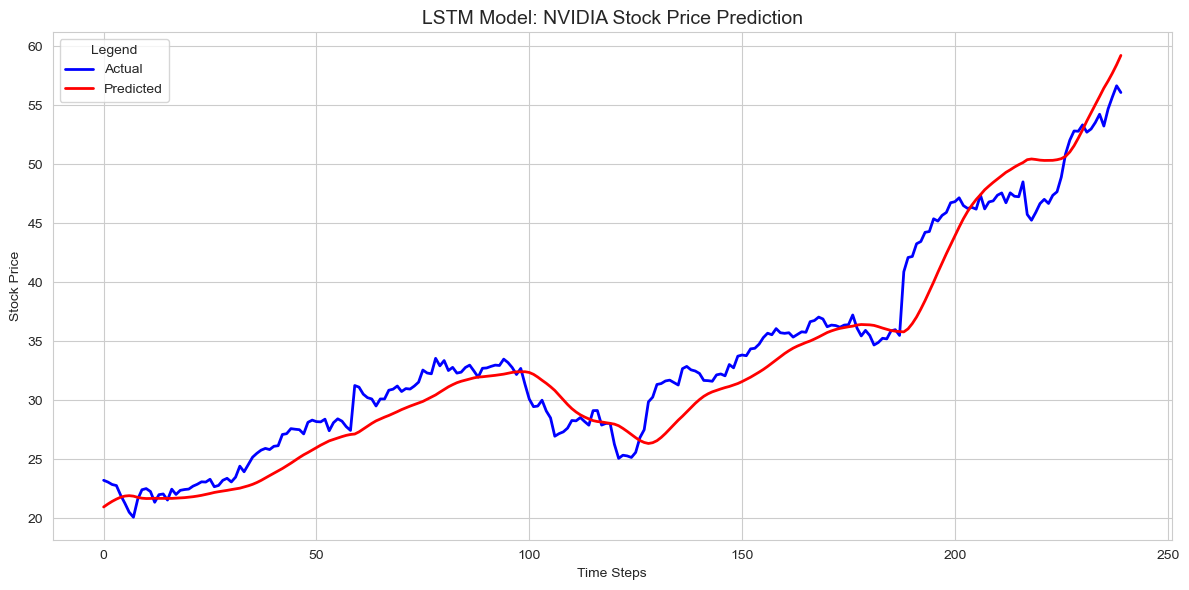

In [32]:
time_steps = np.arange(len(y_true_inv))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(time_steps, y_true_inv, label='Actual', color='blue', linewidth=2)
plt.plot(time_steps, y_pred_inv, label='Predicted', color='red', linewidth=2)

plt.title('LSTM Model: NVIDIA Stock Price Prediction', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend(title='Legend')
plt.tight_layout()
plt.show()

Evaluation metrics was already really good, but this plot even strengthens LSTM's power and precision 

Now let's see how will 1D CNN will perform

In [35]:
# CNN for NVIDIA
BASE_SEED = 42
set_seed(BASE_SEED)

def build_cnn_model(lookback):
    model = Sequential([
        Input(shape=(lookback, 1)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []
all_metrics = pd.DataFrame(columns=['Model', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])

warnings.filterwarnings('ignore')

for i in range(5):
    print(f"\nRunning 1D CNN Model {i+1}/5")
    set_seed(BASE_SEED + i)

    model = build_cnn_model(X_train_nvda.shape[1])

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_nvda, y_train_nvda,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0,
        shuffle=False
    )

    y_pred = model.predict(X_test_nvda)

    y_true_reshaped = y_test_nvda.reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)

    y_true_transform = np.zeros((len(y_true_reshaped), nvda_scaler.n_features_in_))
    y_pred_transform = np.zeros((len(y_pred_reshaped), nvda_scaler.n_features_in_))
    y_true_transform[:, 0] = y_true_reshaped.flatten()
    y_pred_transform[:, 0] = y_pred_reshaped.flatten()

    y_true_inv = nvda_scaler.inverse_transform(y_true_transform)[:, 0]
    y_pred_inv = nvda_scaler.inverse_transform(y_pred_transform)[:, 0]

    mse = mean_squared_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)
    mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100
    cos_sim = cosine_similarity(y_true_inv.reshape(-1, 1), y_pred_inv.reshape(-1, 1))

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mape_list.append(mape)
    cosine_list.append(cos_sim)

    all_metrics = pd.concat([all_metrics, pd.DataFrame([{
        'Model': 'CNN',
        'Run': i+1,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'CosineSim': cos_sim
    }])], ignore_index=True)

print("\nAverage 1D CNN Model Evaluation Over 5 Runs:")
print(f"Avg MSE:  {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE:  {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.4f}%")
print(f"Avg R²:   {np.mean(r2_list):.4f}")
print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\n1D CNN Model Statistics:")
print(all_metrics[all_metrics['Model'] == 'CNN'].describe()[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']])


Running 1D CNN Model 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Running 1D CNN Model 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Running 1D CNN Model 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Running 1D CNN Model 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Running 1D CNN Model 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Average 1D CNN Model Evaluation Over 5 Runs:
Avg MSE:  29.0476
Avg RMSE: 5.1195
Avg MAE:  4.2249
Avg MAPE: 11.5392%
Avg R²:   0.6216
Avg CosineSim: 0.9964

1D CNN Model Statistics:
             MSE      RMSE       MAE        R²       MAPE  CosineSim
count   5.000000  5.000000  5.000000  5.000000   5.000000   5.000000
mean   29.047599  5.119526  4.224901  0.621571  11.539191   0.996384
std    20.505183  1.883500  1.553104  0.267139   4.042307   0.001467
min    12.319435  3.509905  2.900547  0.295716   8.150410   0.994400
25%    13.182162  3.630725  2.980447  0.367029   8.267185   0.995232
50%    17.090932  4.134118  3.425753  0.777341   9.424715   0.997227
75%    48.585819

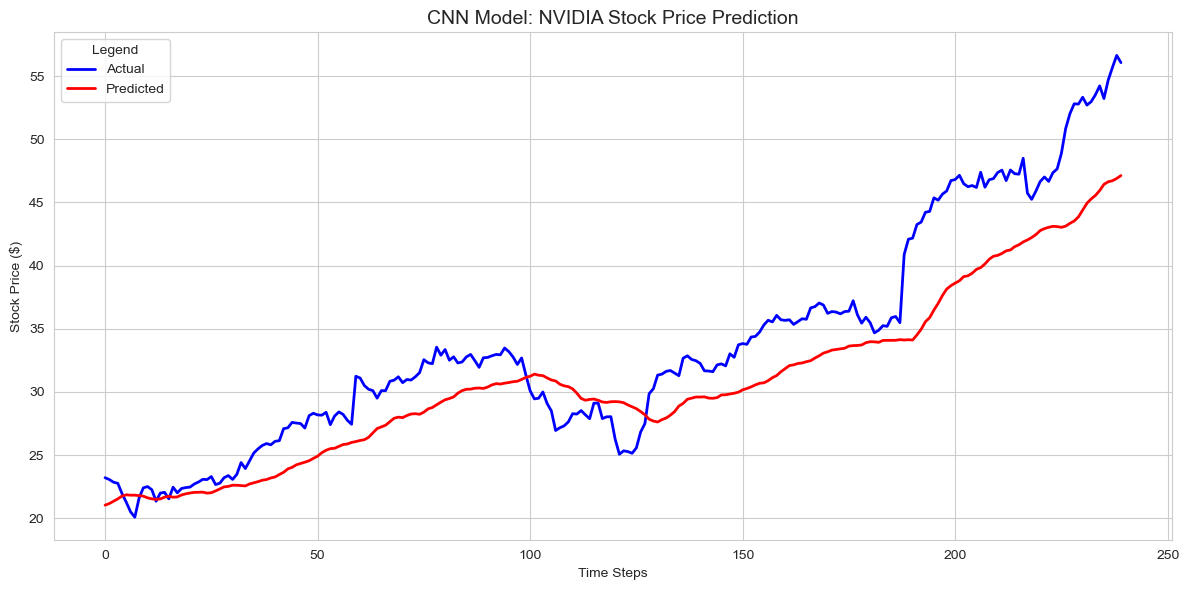

In [36]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(time_steps, y_true_inv, label='Actual', color='blue', linewidth=2)
plt.plot(time_steps, y_pred_inv, label='Predicted', color='red', linewidth=2)

plt.title('CNN Model: NVIDIA Stock Price Prediction', fontsize=14)
plt.xlabel('Time Steps')
plt.ylabel('Stock Price ($)')
plt.legend(title='Legend')
plt.tight_layout()
plt.show()

Again, pretty decent metrics and plot precision, but not as good as LSTM's. So far LSTM is our first placer

Now let's see if Prophet is any good compared to this 2 models that we already evaluated

In [39]:
df = nvda.rename(columns={'Date': 'ds', 'nvda': 'y'})

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values('ds').reset_index(drop=True)

df = df.set_index('ds').asfreq('D')
df = df.reset_index()

df['y'] = df['y'].fillna(method='ffill')

In [40]:
# Prophet for NVIDIA
warnings.filterwarnings('ignore')
logging.getLogger("NP").setLevel(logging.CRITICAL)
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    cos_sim = cosine_similarity(y_true, y_pred)
    return mse, rmse, mae, r2, mape, cos_sim

split_idx = int(len(df) * 0.9)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []
all_metrics = pd.DataFrame(columns=['Model', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])

BASE_SEED = 42

for i in range(5):
    print(f"\nRunning NeuralProphet Model {i+1}/5")
    set_seed(BASE_SEED + i)

    model = NeuralProphet(epochs=100)
    model.fit(train_df, freq='D', progress='off')

    future = model.make_future_dataframe(train_df, periods=len(test_df))
    forecast = model.predict(future)

    y_true = test_df['y'].values
    y_pred = forecast['yhat1'].iloc[-len(test_df):].values

    mse, rmse, mae, r2, mape, cos_sim = evaluate_metrics(y_true, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mape_list.append(mape)
    cosine_list.append(cos_sim)

    all_metrics = pd.concat([all_metrics, pd.DataFrame([{
        'Model': 'NeuralProphet',
        'Run': i+1,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'CosineSim': cos_sim
    }])], ignore_index=True)

print("\nAverage NeuralProphet Model Evaluation Over 5 Runs:")
print(f"Avg MSE:       {np.mean(mse_list):.4f}")
print(f"Avg RMSE:      {np.mean(rmse_list):.4f}")
print(f"Avg MAE:       {np.mean(mae_list):.4f}")
print(f"Avg MAPE:      {np.mean(mape_list):.4f}%")
print(f"Avg R²:        {np.mean(r2_list):.4f}")
print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\nNeuralProphet Model Statistics Summary:")
print(all_metrics.describe()[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']])


Running NeuralProphet Model 1/5


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]


Running NeuralProphet Model 2/5


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]


Running NeuralProphet Model 3/5


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]


Running NeuralProphet Model 4/5


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]


Running NeuralProphet Model 5/5


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 52it [00:00, ?it/s]


Average NeuralProphet Model Evaluation Over 5 Runs:
Avg MSE:       127.7364
Avg RMSE:      11.3019
Avg MAE:       8.6406
Avg MAPE:      19.5805%
Avg R²:        -0.8730
Avg CosineSim: 0.9786

NeuralProphet Model Statistics Summary:
              MSE       RMSE       MAE        R²       MAPE  CosineSim
count    5.000000   5.000000  5.000000  5.000000   5.000000   5.000000
mean   127.736413  11.301941  8.640585 -0.873034  19.580504   0.978638
std      1.271124   0.056246  0.038725  0.018639   0.095321   0.000618
min    126.116084  11.230142  8.581354 -0.896211  19.433352   0.978016
25%    126.844325  11.262519  8.632262 -0.883293  19.557418   0.978223
50%    127.968601  11.312321  8.645981 -0.876439  19.600366   0.978367
75%    128.436013  11.332961  8.656497 -0.859953  19.620643   0.979146
max    129.317041  11.371765  8.686831 -0.849275  19.690742   0.979437


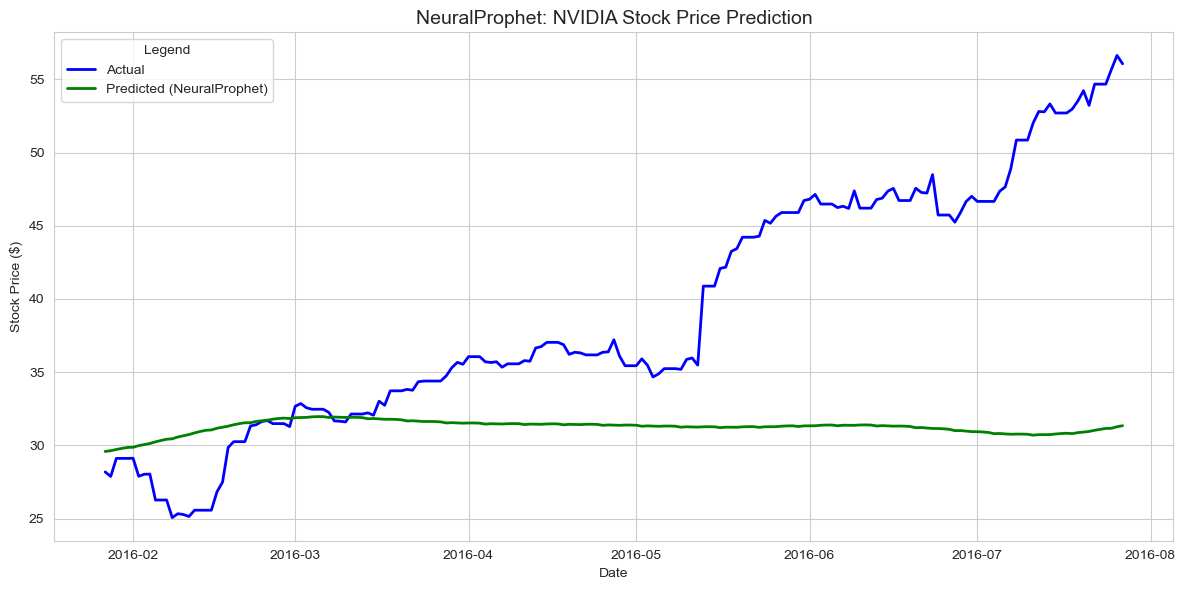

In [41]:
dates = test_df['ds'].values

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(dates, y_true, label='Actual', color='blue', linewidth=2)
plt.plot(dates, y_pred, label='Predicted (NeuralProphet)', color='green', linewidth=2)

plt.title('NeuralProphet: NVIDIA Stock Price Prediction', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(title='Legend')
plt.tight_layout()
plt.show()

As it turns out, Neural Prophet is not as good for stock prices predictions, because as its metrics already showed, this plot looks even worse, suggesting that Neural Prophet is useless in our case

Okay lets summarize our 3 different types of models and their evaluation results:

**LSTM Model**:
- MSE: 9.02
- RMSE: 2.96
- MAE: 2.40
- MAPE: 6.85%
- R²: 0.8825
- Cosine Similarity: 0.9978

Performance Summary: Best performing model overall. Very low error values across all metrics. High R² indicates that 88% of the variance in stock prices is explained by the model. Cosine similarity near 1 shows very close directional alignment between predictions and actual values. Low standard deviation across runs implies stable and consistent performance.

**1D CNN Model**:
- MSE: 29.05
- RMSE: 5.12
- MAE: 4.22
- MAPE: 11.54%
- R²: 0.6216
- Cosine Similarity: 0.9964

Performance Summary:
Moderate performance. Higher error metrics than LSTM: about 3x MSE and 2x MAE. R² = 0.62 indicates moderate ability to explain variance. Good cosine similarity suggests predictions follow correct trends, despite larger magnitude errors. Larger standard deviation than LSTM, less consistent across runs.

**Neural Prophet**:
- MSE: 129.59
- RMSE: 11.38
- MAE: 8.68
- MAPE: 19.68%
- R²: -0.9002
- Cosine Similarity: 0.9777

Performance Summary:
Significantly underperformed. Highest errors among all models. Negative R² suggests the model performs worse than simply predicting the mean value. Cosine similarity lower than other models but still relatively high captures trends but fails at value precision. Very low variance across runs → consistently poor performance.


## Multi-Stock Models Benchmarking and Evaluation

In [45]:
df = all.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [46]:
# LSTM for multi-stock
warnings.filterwarnings("ignore")

BASE_SEED = 42

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

SEQ_LEN = 40
RUNS = 3
EPOCHS = 50
BATCH_SIZE = 64

all.set_index('Date', inplace=True)
all.index = pd.to_datetime(all.index)

all_metrics = pd.DataFrame(columns=['Stock', 'Model', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])

prediction_results = {}

for stock in all.columns:
    print(f"\n=== Processing {stock.upper()} ===")
    stock_data = all[[stock]].dropna()

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(stock_data)

    X, y = create_sequences(scaled_data, SEQ_LEN)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []
    stock_predictions = []

    for run in range(RUNS):
        print(f"  Run {run + 1}/{RUNS}")
        set_seed(BASE_SEED + run)

        model = build_lstm_model(SEQ_LEN)
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0,
            shuffle=False
        )

        y_pred = model.predict(X_test)

        y_true_reshaped = y_test.reshape(-1, 1)
        y_pred_reshaped = y_pred.reshape(-1, 1)

        y_true_transform = np.zeros((len(y_true_reshaped), scaler.n_features_in_))
        y_pred_transform = np.zeros((len(y_pred_reshaped), scaler.n_features_in_))
        y_true_transform[:, 0] = y_true_reshaped.flatten()
        y_pred_transform[:, 0] = y_pred_reshaped.flatten()

        y_true_inv = scaler.inverse_transform(y_true_transform)[:, 0]
        y_pred_inv = scaler.inverse_transform(y_pred_transform)[:, 0]

        stock_predictions.append({
            'run': run,
            'y_true_inv': y_true_inv,
            'y_pred_inv': y_pred_inv
        })

        mse = mean_squared_error(y_true_inv, y_pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        r2 = r2_score(y_true_inv, y_pred_inv)
        mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100
        cos_sim = cosine_similarity(y_true_inv, y_pred_inv)

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        mape_list.append(mape)
        cosine_list.append(cos_sim)

        all_metrics = pd.concat([all_metrics, pd.DataFrame([{
            'Stock': stock.upper(),
            'Model': 'LSTM',
            'Run': run + 1,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape,
            'CosineSim': cos_sim
        }])], ignore_index=True)
    
    prediction_results[stock.upper()] = stock_predictions

    print(f"Avg MSE:  {np.mean(mse_list):.4f}")
    print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
    print(f"Avg MAE:  {np.mean(mae_list):.4f}")
    print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
    print(f"Avg R²:   {np.mean(r2_list):.4f}")
    print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\n\n==== All Model Statistics ====")
print(all_metrics.groupby("Stock")[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']].mean().round(4))


=== Processing NVDA ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Avg MSE:  7.7048
Avg RMSE: 2.7688
Avg MAE:  2.3267
Avg MAPE: 7.08%
Avg R²:   0.9002
Avg CosineSim: 0.9972

=== Processing APPL ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Avg MSE:  26.4356
Avg RMSE: 5.1166
Avg MAE:  4.0897
Avg MAPE: 3.95%
Avg R²:   0.5922
Avg CosineSim: 0.9989

=== Processing MSFT ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Avg MSE:  5.5065
Avg RMSE: 2.3323
Avg MAE:  1.7435
Avg MAPE: 3.46%
Avg R²:   0.6464
Avg CosineSim: 0.9990

=== Processing AMZN ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Avg M

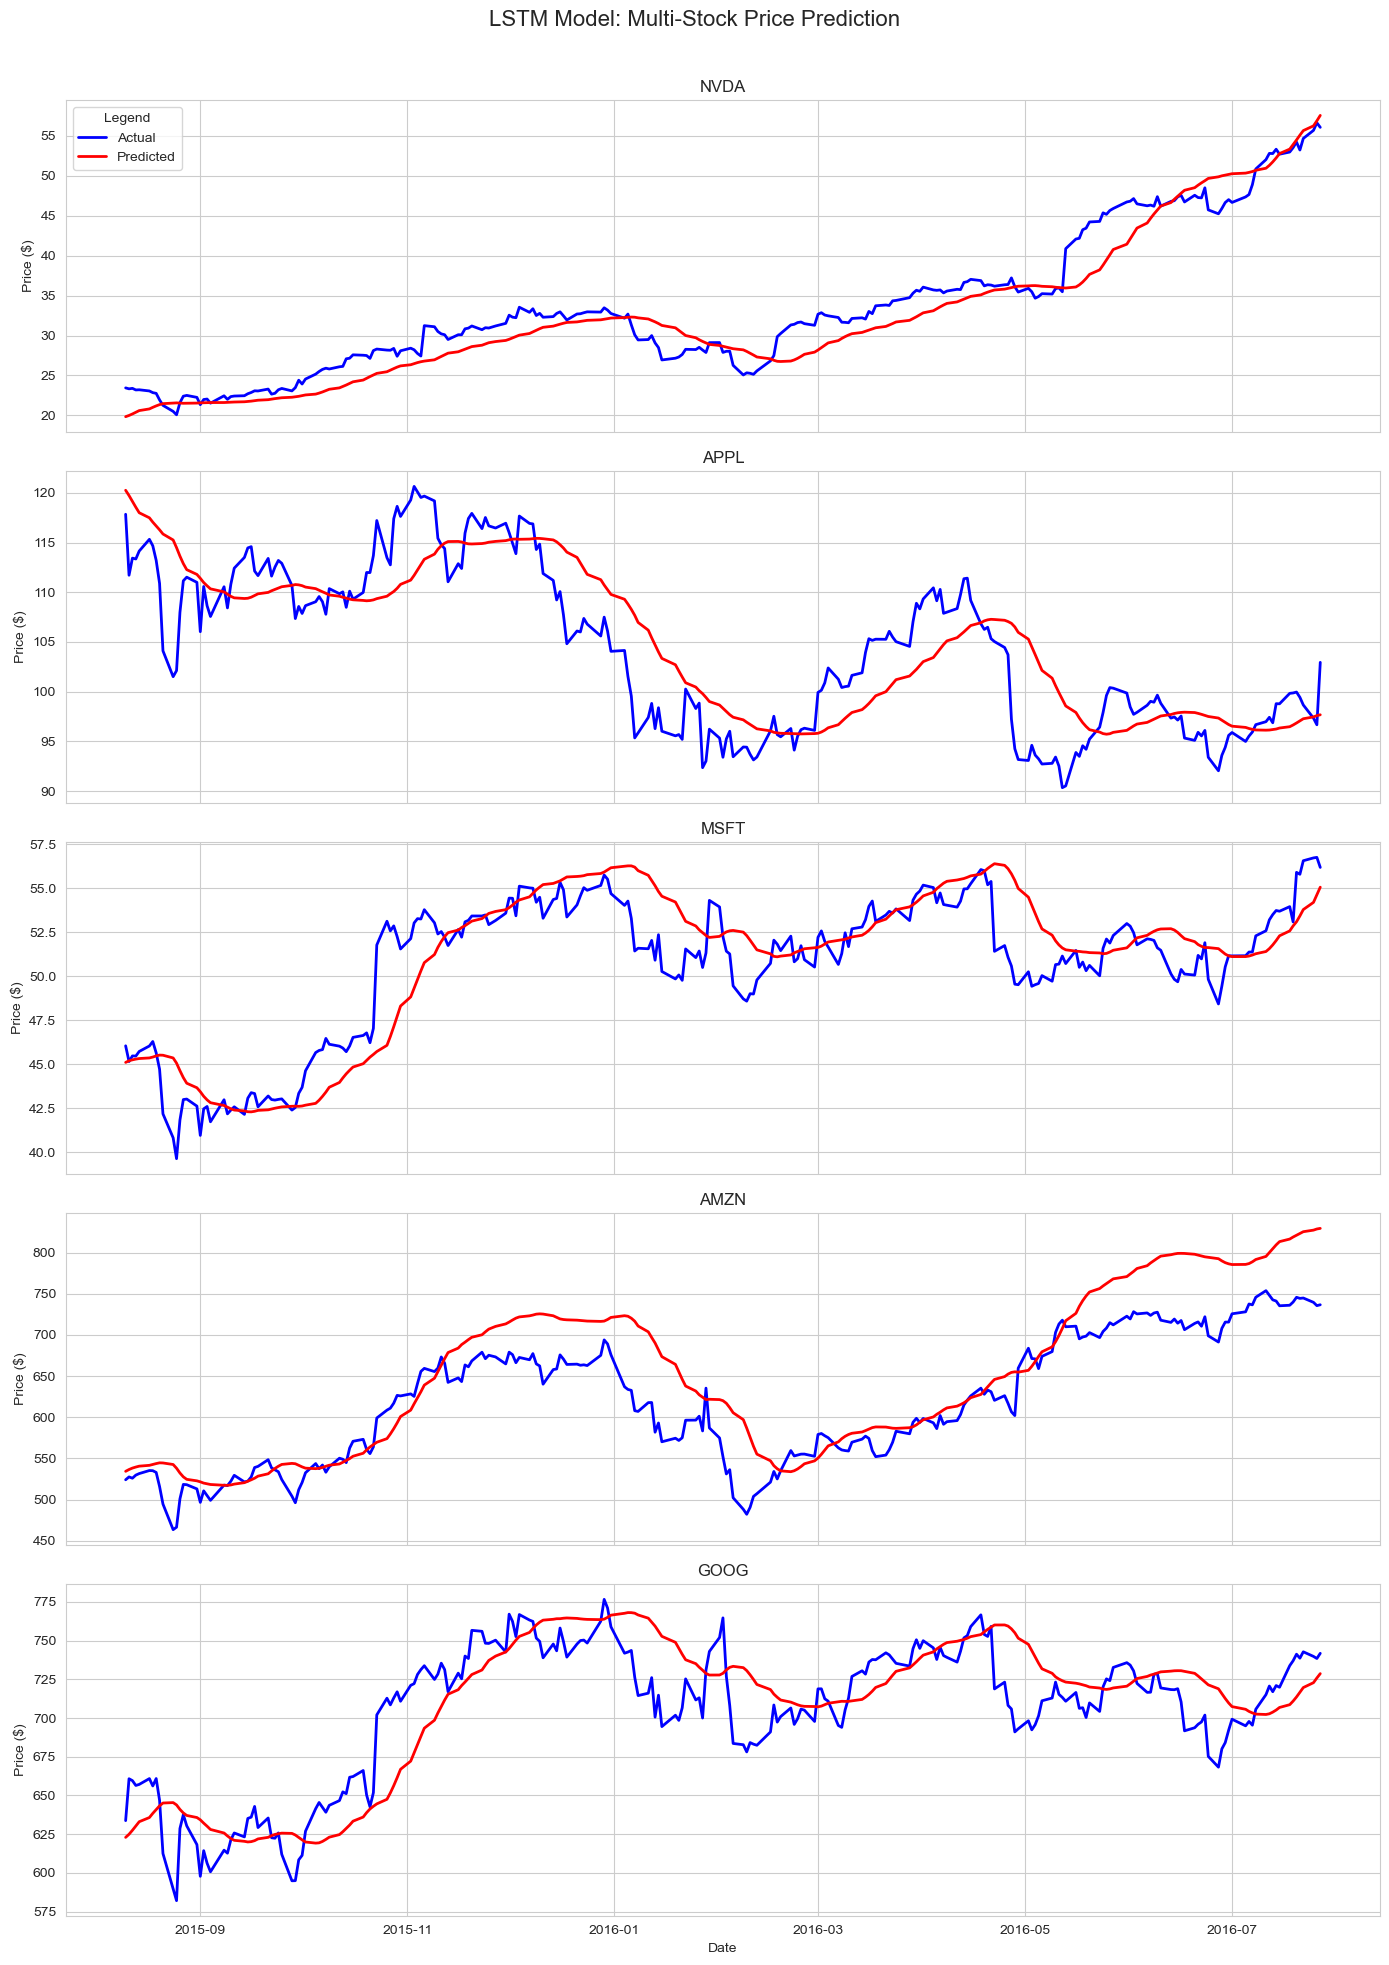

In [47]:
stocks = all_metrics['Stock'].unique()
num_stocks = len(stocks)
test_dates = {}

fig, axes = plt.subplots(num_stocks, 1, figsize=(14, 4 * num_stocks), sharex=True)
sns.set_style("whitegrid")

if num_stocks == 1:
    axes = [axes]

for i, stock_name in enumerate(stocks):
    stock_data = all[[stock_name.lower()]].dropna()
    split_idx = int(0.8 * (len(stock_data) - SEQ_LEN))
    test_dates[stock_name] = stock_data.index[SEQ_LEN + split_idx:]
    
    stock_metrics = all_metrics[all_metrics['Stock'] == stock_name]
    avg_metrics = stock_metrics.mean(numeric_only=True)
    
    best_run = stock_metrics.loc[stock_metrics['RMSE'].idxmin()]['Run']
    run_idx = int(best_run) - 1
    
    y_true_inv = prediction_results[stock_name][run_idx]['y_true_inv']
    y_pred_inv = prediction_results[stock_name][run_idx]['y_pred_inv']
    
    ax = axes[i]
    ax.plot(test_dates[stock_name], y_true_inv, label='Actual', color='blue', linewidth=2)
    ax.plot(test_dates[stock_name], y_pred_inv, label='Predicted', color='red', linewidth=2)
    ax.set_ylabel("Price ($)")
    ax.set_title(f"{stock_name}")

axes[-1].set_xlabel("Date")
axes[0].legend(title='Legend')
plt.suptitle('LSTM Model: Multi-Stock Price Prediction', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

And not surprisingly, for the multi-stock forecatsing LSTM is still great. It showed precise forecasting in metrics and visually too. Let's see if CNN can beat our winner so far

In [49]:
# CNN for multi-stock
SEQ_LEN = 40
RUNS = 3
EPOCHS = 50
BATCH_SIZE = 64
BASE_SEED = 42

df = all.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

X, y = create_sequences(scaled_data, SEQ_LEN)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

all_metrics = pd.DataFrame(columns=['Stock', 'Model', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])

predictions = {}
actual_values = {}
test_dates = {}

for stock in df.columns:
    print(f"\n=== Processing {stock.upper()} ===")
    stock_data = df[[stock]].dropna()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(stock_data)

    X, y = create_sequences(scaled, SEQ_LEN)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    
    split_idx = int(0.8 * (len(stock_data) - SEQ_LEN))
    test_dates[stock.upper()] = stock_data.index[SEQ_LEN + split_idx:]

    mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []
    
    best_rmse = float('inf')
    best_y_true = None
    best_y_pred = None

    for run in range(RUNS):
        print(f"  Run {run+1}/{RUNS}")
        set_seed(BASE_SEED + run)

        model = build_cnn_model(SEQ_LEN)
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        model.fit(
            X_train_reshaped, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0,
            shuffle=False
        )

        y_pred = model.predict(X_test_reshaped)
        y_true_reshaped = y_test.reshape(-1, 1)
        y_pred_reshaped = y_pred.reshape(-1, 1)

        y_true_transform = np.zeros((len(y_true_reshaped), scaler.n_features_in_))
        y_pred_transform = np.zeros((len(y_pred_reshaped), scaler.n_features_in_))
        y_true_transform[:, 0] = y_true_reshaped.flatten()
        y_pred_transform[:, 0] = y_pred_reshaped.flatten()

        y_true_inv = scaler.inverse_transform(y_true_transform)[:, 0]
        y_pred_inv = scaler.inverse_transform(y_pred_transform)[:, 0]

        mse = mean_squared_error(y_true_inv, y_pred_inv)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_inv, y_pred_inv)
        r2 = r2_score(y_true_inv, y_pred_inv)
        mape = np.mean(np.abs((y_true_inv - y_pred_inv) / y_true_inv)) * 100
        cos_sim = cosine_similarity(y_true_inv, y_pred_inv)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_y_true = y_true_inv
            best_y_pred = y_pred_inv

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        mape_list.append(mape)
        cosine_list.append(cos_sim)

        all_metrics = pd.concat([all_metrics, pd.DataFrame([{
            'Stock': stock.upper(),
            'Model': 'CNN',
            'Run': run + 1,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape,
            'CosineSim': cos_sim
        }])], ignore_index=True)

    actual_values[stock.upper()] = best_y_true
    predictions[stock.upper()] = best_y_pred
    
    print(f"Avg MSE:  {np.mean(mse_list):.4f}")
    print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
    print(f"Avg MAE:  {np.mean(mae_list):.4f}")
    print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
    print(f"Avg R²:   {np.mean(r2_list):.4f}")
    print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\n\n==== All Model Statistics ====")
print(all_metrics.groupby("Stock")[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']].mean().round(4))


=== Processing NVDA ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Avg MSE:  25.6638
Avg RMSE: 4.8567
Avg MAE:  4.0080
Avg MAPE: 11.06%
Avg R²:   0.6677
Avg CosineSim: 0.9966

=== Processing APPL ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Avg MSE:  55.2535
Avg RMSE: 7.3817
Avg MAE:  5.7971
Avg MAPE: 5.72%
Avg R²:   0.1476
Avg CosineSim: 0.9984

=== Processing MSFT ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Avg MSE:  7.7683
Avg RMSE: 2.7865
Avg MAE:  2.2546
Avg MAPE: 4.44%
Avg R²:   0.5012
Avg CosineSim: 0.9986

=== Processing AMZN ===
  Run 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
  Run 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
  Run 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Avg MSE:

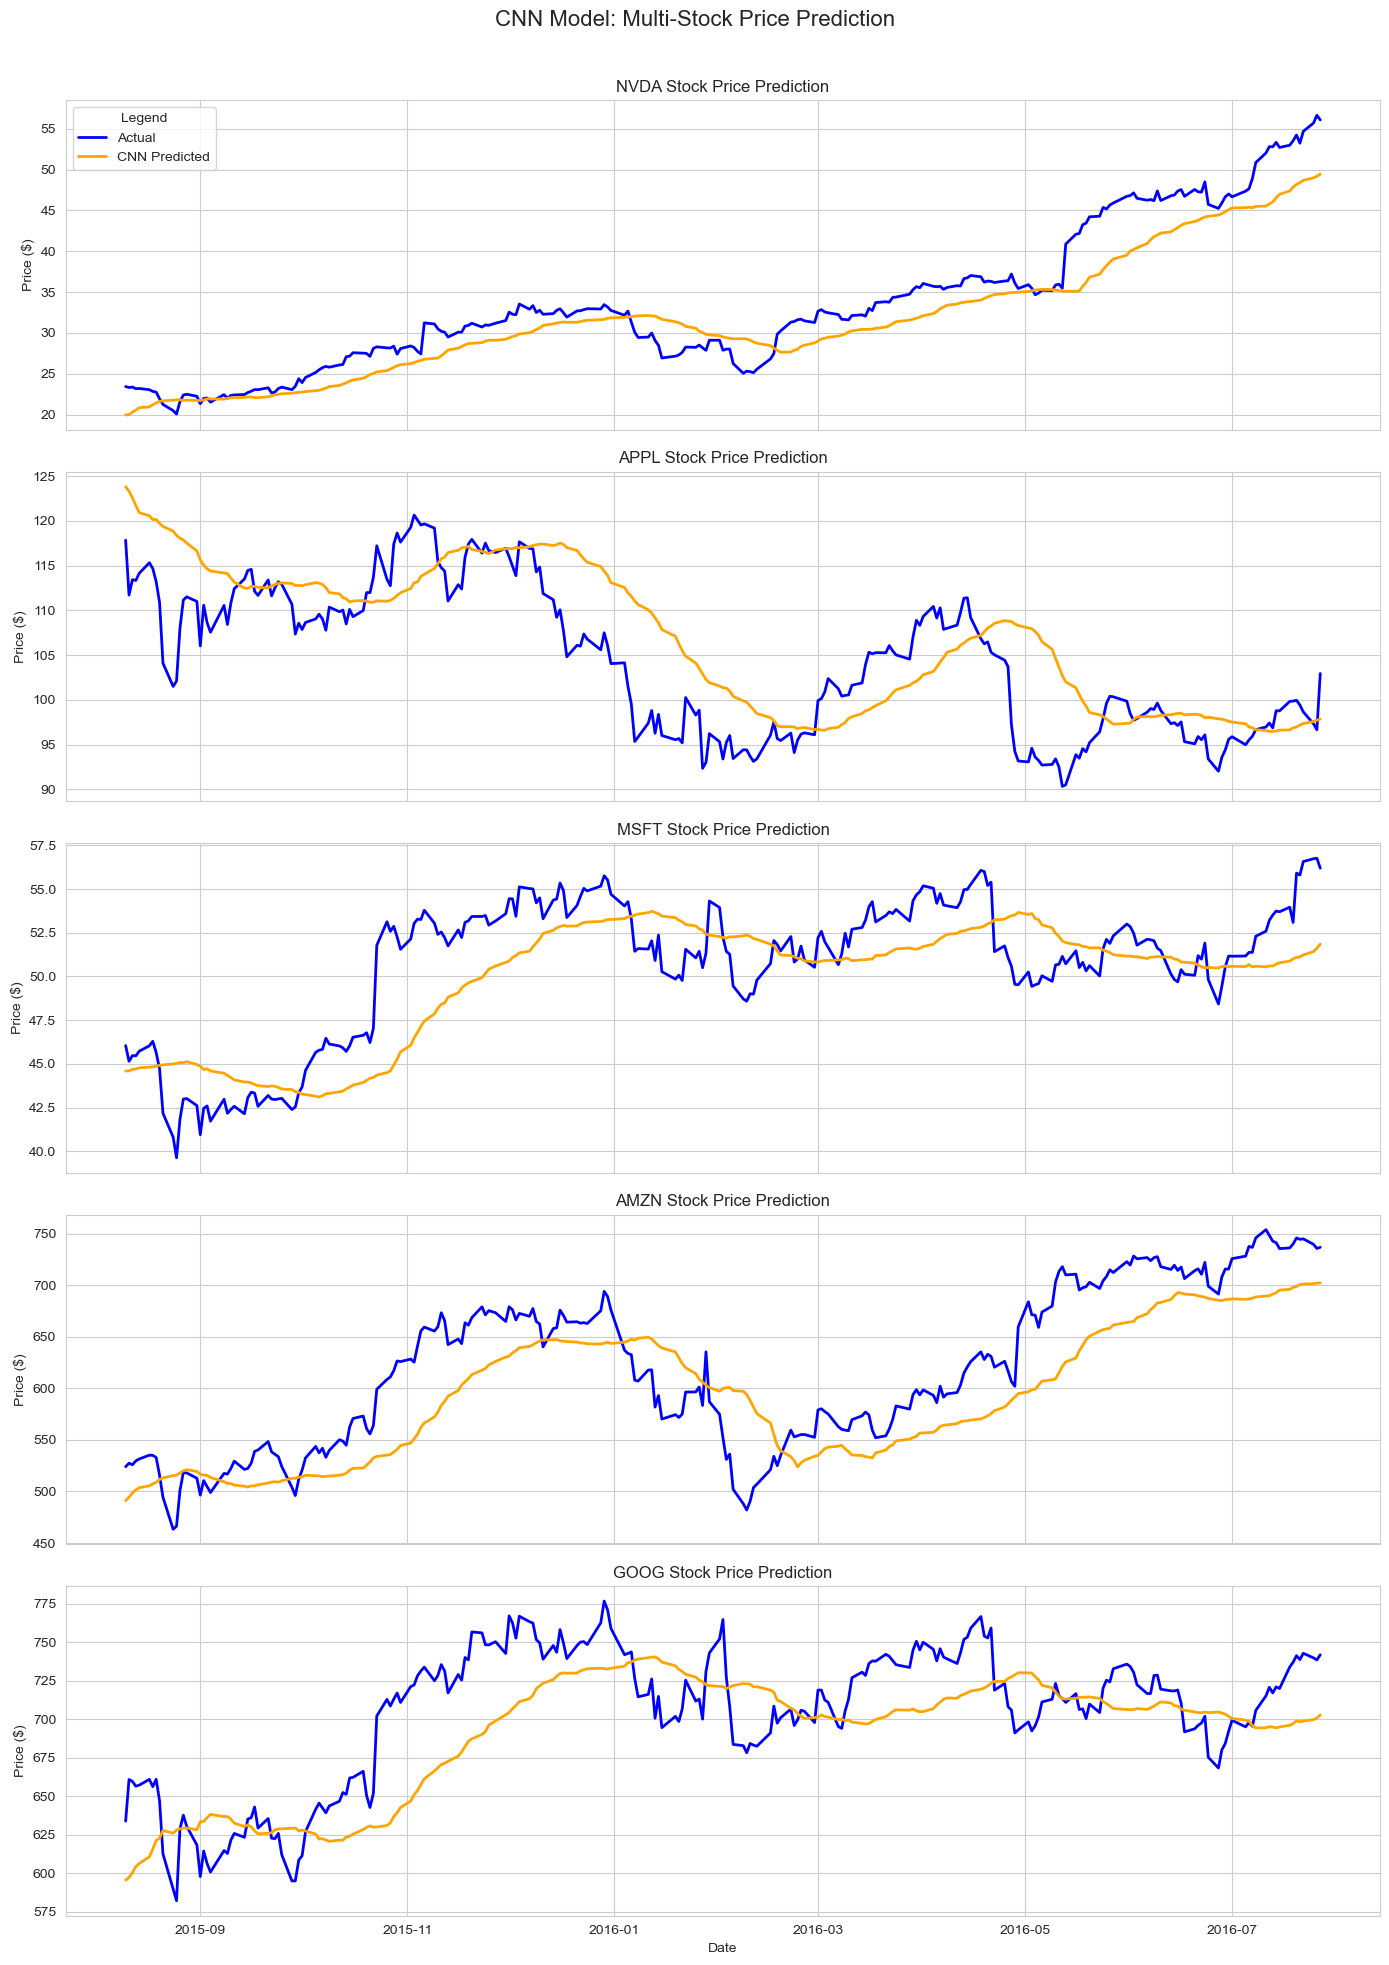

In [50]:
stocks = all_metrics[all_metrics['Model'] == 'CNN']['Stock'].unique()
num_stocks = len(stocks)

fig, axes = plt.subplots(num_stocks, 1, figsize=(14, 4 * num_stocks), sharex=True)
sns.set_style("whitegrid")

if num_stocks == 1:
    axes = [axes]

for i, stock_name in enumerate(stocks):
    stock_metrics = all_metrics[(all_metrics['Stock'] == stock_name) & (all_metrics['Model'] == 'CNN')]
    avg_metrics = stock_metrics.mean(numeric_only=True)

    ax = axes[i]
    ax.plot(test_dates[stock_name], actual_values[stock_name], label='Actual', color='blue', linewidth=2)
    ax.plot(test_dates[stock_name], predictions[stock_name], label='CNN Predicted', color='orange', linewidth=2)
    ax.set_ylabel("Price ($)")
    ax.set_title(f"{stock_name} Stock Price Prediction")
    if i == 0:
        ax.legend(title='Legend')

axes[-1].set_xlabel("Date")
plt.suptitle('CNN Model: Multi-Stock Price Prediction', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

As expected, CNN is actually pretty good forecasting NN method, but LSTM is again the greatest performer out of all. I do not expect much from the Neural Prophet, based on the experience we have seen, but let's check it out for multi-stock as well

In [52]:
nvda = all.reset_index()[['Date', 'nvda']].rename(columns={'Date': 'ds', 'nvda': 'y'})
nvda['ticker'] = 'nvda'

msft = all.reset_index()[['Date', 'msft']].rename(columns={'Date': 'ds', 'msft': 'y'})
msft['ticker'] = 'msft'

appl = all.reset_index()[['Date', 'appl']].rename(columns={'Date': 'ds', 'appl': 'y'})
appl['ticker'] = 'appl'

goog = all.reset_index()[['Date', 'goog']].rename(columns={'Date': 'ds', 'goog': 'y'})
goog['ticker'] = 'goog'

amzn = all.reset_index()[['Date', 'amzn']].rename(columns={'Date': 'ds', 'amzn': 'y'})
amzn['ticker'] = 'amzn'

combined_data = pd.concat([nvda, msft, appl, goog, amzn])

In [53]:
# Prophet for multi-stock
warnings.filterwarnings('ignore')
logging.getLogger("NP").setLevel(logging.CRITICAL)
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)
logging.getLogger("prophet").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger().setLevel(logging.CRITICAL)

tickers = combined_data['ticker'].unique()

mse_list, rmse_list, mae_list, r2_list, mape_list, cosine_list = [], [], [], [], [], []
all_metrics = pd.DataFrame(columns=['Model', 'Ticker', 'Run', 'MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim'])

BASE_SEED = 42

best_predictions = {}
test_data = {}

for ticker in tickers:
    print(f"\nModeling for {ticker}")

    ticker_data = combined_data[combined_data['ticker'] == ticker]

    split_idx = int(len(ticker_data) * 0.9)
    train_df = ticker_data.iloc[:split_idx]
    test_df = ticker_data.iloc[split_idx:]
    
    test_data[ticker] = test_df
    
    best_rmse = float('inf')
    best_prediction = None

    for i in range(5):
        print(f"\nRunning NeuralProphet Model {i+1}/5 for {ticker}")
        set_seed(BASE_SEED + i)

        model = NeuralProphet(epochs=100)
        model.fit(train_df[['ds', 'y']], freq='D', progress='off')

        future = model.make_future_dataframe(train_df[['ds', 'y']], periods=len(test_df))
        forecast = model.predict(future)

        y_true = test_df['y'].values
        y_pred = forecast['yhat1'].iloc[-len(test_df):].values

        mse, rmse, mae, r2, mape, cos_sim = evaluate_metrics(y_true, y_pred)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_prediction = y_pred

        mse_list.append(mse)
        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)
        mape_list.append(mape)
        cosine_list.append(cos_sim)

        all_metrics = pd.concat([all_metrics, pd.DataFrame([{
            'Model': 'NeuralProphet',
            'Ticker': ticker,
            'Run': i+1,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape,
            'CosineSim': cos_sim
        }])], ignore_index=True)
    
    best_predictions[ticker] = best_prediction

print("\nAverage NeuralProphet Model Evaluation Over 5 Runs for All Stocks:")
print(f"Avg MSE:       {np.mean(mse_list):.4f}")
print(f"Avg RMSE:      {np.mean(rmse_list):.4f}")
print(f"Avg MAE:       {np.mean(mae_list):.4f}")
print(f"Avg MAPE:      {np.mean(mape_list):.4f}%")
print(f"Avg R²:        {np.mean(r2_list):.4f}")
print(f"Avg CosineSim: {np.mean(cosine_list):.4f}")

print("\nNeuralProphet Model Statistics Summary:")
print(all_metrics.groupby('Ticker').describe()[['MSE', 'RMSE', 'MAE', 'R²', 'MAPE', 'CosineSim']])


Modeling for nvda

Running NeuralProphet Model 1/5 for nvda


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 2/5 for nvda


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 3/5 for nvda


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 4/5 for nvda


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 5/5 for nvda


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Modeling for msft

Running NeuralProphet Model 1/5 for msft


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 2/5 for msft


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 3/5 for msft


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 4/5 for msft


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 5/5 for msft


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Modeling for appl

Running NeuralProphet Model 1/5 for appl


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 2/5 for appl


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 3/5 for appl


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 4/5 for appl


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 5/5 for appl


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Modeling for goog

Running NeuralProphet Model 1/5 for goog


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 2/5 for goog


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 3/5 for goog


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 4/5 for goog


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 5/5 for goog


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Modeling for amzn

Running NeuralProphet Model 1/5 for amzn


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 2/5 for amzn


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 3/5 for amzn


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 4/5 for amzn


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Running NeuralProphet Model 5/5 for amzn


Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 36it [00:00, ?it/s]


Average NeuralProphet Model Evaluation Over 5 Runs for All Stocks:
Avg MSE:       24649.1527
Avg RMSE:      105.9037
Avg MAE:       66.3900
Avg MAPE:      26.3786%
Avg R²:        -69.6447
Avg CosineSim: 0.9151

NeuralProphet Model Statistics Summary:
         MSE                                                          \
       count          mean           std           min           25%   
Ticker                                                                 
amzn     5.0  68382.628898  69389.436977  18488.749814  28430.248048   
appl     5.0   4341.580399   5222.096966    421.147399    755.205951   
goog     5.0  49735.031496  50638.068943   8378.601960  18043.542935   
msft     5.0    280.024381    337.068224     13.232690     42.655306   
nvda     5.0    506.498556    646.746588    113.254408    124.792212   

                                                   RMSE              ...  \
                 50%           75%            max count        mean  ...   
Ticker             

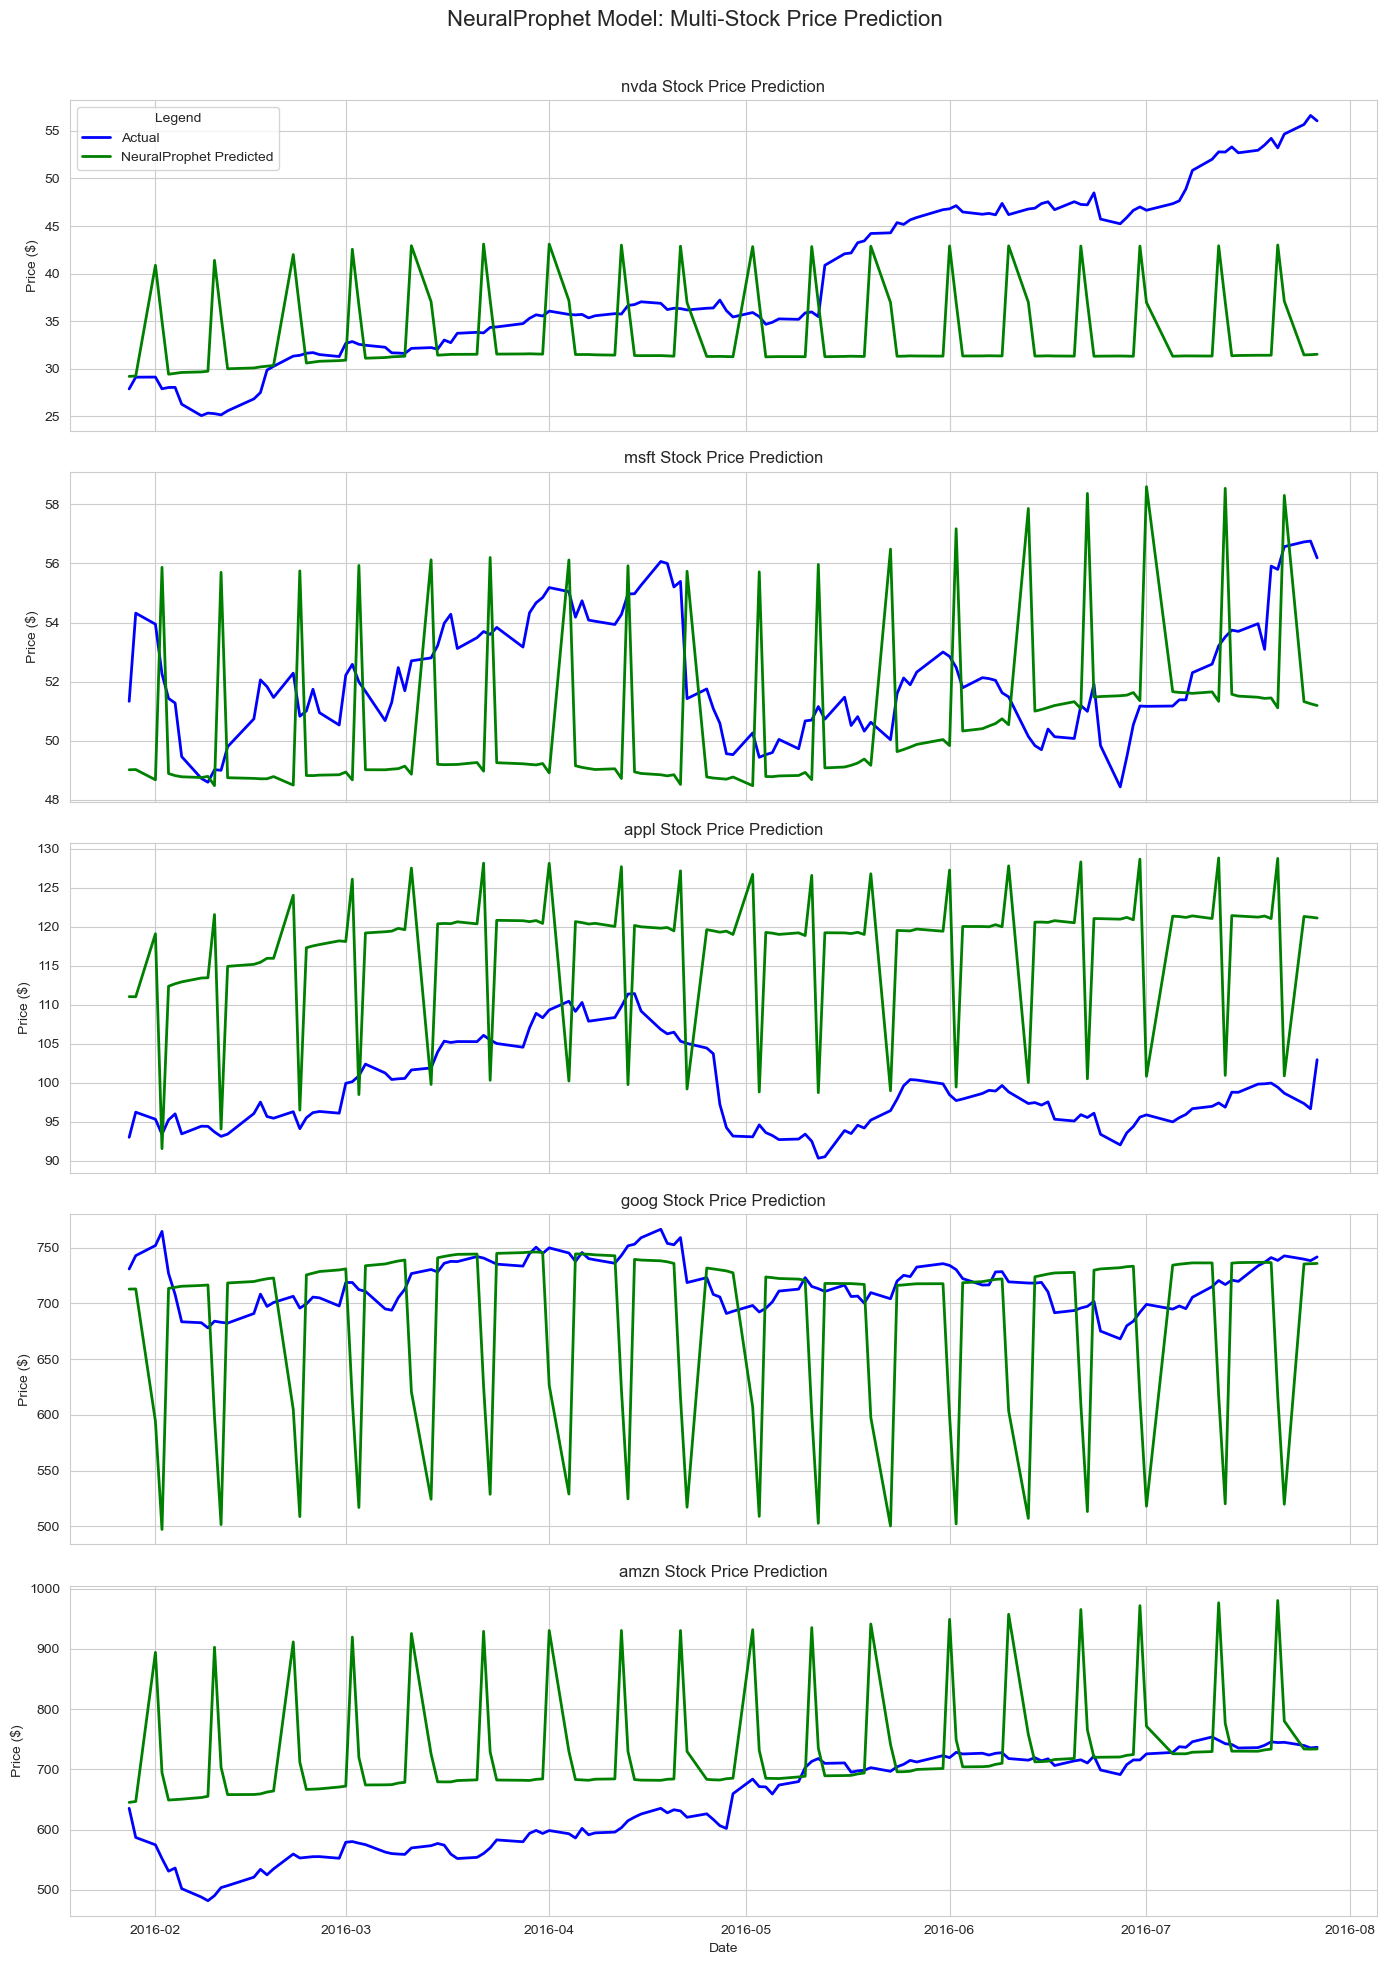

In [54]:
unique_tickers = all_metrics['Ticker'].unique()
num_tickers = len(unique_tickers)

fig, axes = plt.subplots(num_tickers, 1, figsize=(14, 4 * num_tickers), sharex=True)
sns.set_style("whitegrid")

if num_tickers == 1:
    axes = [axes]

for i, ticker in enumerate(unique_tickers):
    test_df = test_data[ticker]
    y_true = test_df['y'].values
    y_pred = best_predictions[ticker]
    dates = test_df['ds'].values

    ax = axes[i]
    ax.plot(dates, y_true, label='Actual', color='blue', linewidth=2)
    ax.plot(dates, y_pred, label='NeuralProphet Predicted', color='green', linewidth=2)
    ax.set_ylabel("Price ($)")
    ax.set_title(f"{ticker} Stock Price Prediction")
    if i == 0:
        ax.legend(title='Legend')

axes[-1].set_xlabel("Date")
plt.suptitle("NeuralProphet Model: Multi-Stock Price Prediction", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

As expected, Neural Prophet is useless for stock price forecasting, in both multi and single price prediction

Now lets overview and summarize our multi-stock price forecasting results:

**LSTM**
- MSE: ~3414
- RMSE: ~33.7
- MAE: ~26.2
- MAPE: ~6.3%
- R²: ~0.42
- Cosine Similarity: ~0.998

The LSTM model shows strong performance across all metrics, particularly with high Cosine Similarity and low MAPE. It demonstrates good generalization on most stocks and is the most accurate and reliable model overall.

**1D CNN**
- MSE: ~785
- RMSE: ~20.3
- MAE: ~16.5
- MAPE: ~6.5%
- R²: ~0.44
- Cosine Similarity: ~0.998

The 1D CNN model performs reasonably well, especially on NVDA and GOOG stocks. It offers a good balance between speed and accuracy, but it shows higher errors than LSTM and underperforms on AAPL.

**NeuralProphet**
- MSE: 80,125
- RMSE: 166.3
- MAE: 97.6
- MAPE: 28.9%
- R²: -152.4
- Cosine Similarity: 0.906

NeuralProphet performs poorly across all metrics, with very high MSE, RMSE, and MAE. Its R² score is negative, suggesting the model is not capturing the data effectively. It is not recommended for stock price forecasting tasks.


Ultimately, to conclude, LSTM is the top performer, providing the most accurate and reliable forecasts. The 1D CNN offers a good alternative when computational efficiency is necessary, but NeuralProphet should be avoided for this specific task.

## Sales Dataset Overview

Let's first import our dataset and preprocess it properly

In [59]:
sales = pd.read_csv(r'C:\Users\user\Desktop\sales.csv')
sales.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,1/1/2022,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,1/1/2022,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,1/1/2022,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,1/1/2022,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,1/1/2022,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [60]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

## Data Preperation

Time to do some preprocessing, creating new time variables, as well as lagged values and feature engineering based on the domain knowledge and variable characteristics

In [63]:
sales['Date'] = pd.to_datetime(sales['Date'])
sales['Year'] = sales['Date'].dt.year
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day
sales['DayOfWeek'] = sales['Date'].dt.dayofweek
sales['Quarter'] = sales['Date'].dt.quarter
sales['IsWeekend'] = sales['Date'].dt.dayofweek >= 5

In [64]:
sales = sales.sort_values(['Store ID', 'Product ID', 'Date'])

for lag in [1, 7, 14, 30]:
    sales[f'Units_Sold_Lag{lag}'] = sales.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(lag)

for window in [7, 14, 30]:
    sales[f'Units_Sold_Mean_{window}d'] = sales.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

In [65]:
sales['Price_After_Discount'] = sales['Price'] * (1 - sales['Discount']/100)
sales['Price_Difference'] = sales['Price'] - sales['Competitor Pricing']
sales['Price_Ratio'] = sales['Price'] / (sales['Competitor Pricing'] + 0.01)

In [66]:
sales = sales.fillna(0)

In [67]:
dates = sorted(sales['Date'].unique())
train_end = dates[int(len(dates) * 0.7)]
val_end = dates[int(len(dates) * 0.85)]

train_data = sales[sales['Date'] <= train_end]
val_data = sales[(sales['Date'] > train_end) & (sales['Date'] <= val_end)]
test_data = sales[sales['Date'] > val_end]

In [68]:
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
numerical_cols = [col for col in sales.columns if col not in categorical_cols + ['Date', 'Units Sold']]

X_train = train_data.drop(['Units Sold', 'Date'], axis=1)
y_train = train_data['Units Sold']
X_val = val_data.drop(['Units Sold', 'Date'], axis=1)
y_val = val_data['Units Sold']
X_test = test_data.drop(['Units Sold', 'Date'], axis=1)
y_test = test_data['Units Sold']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
    X_val_processed = X_val_processed.toarray()
    X_test_processed = X_test_processed.toarray()

Okay so we have created some new features, engineered some of them and also splitted our dataset properly, not it is time to train our models on them and see who is the best performer

## Model Benchamrking and Evaluation

In [71]:
# Feedforward Neural Network
input_shape = X_train_processed.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_processed, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val_processed, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8703.6279 - mae: 58.3876 - val_loss: 120.6787 - val_mae: 9.0463
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 464.1912 - mae: 15.8798 - val_loss: 121.7403 - val_mae: 8.9639
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 396.1627 - mae: 14.5253 - val_loss: 112.9359 - val_mae: 8.6544
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 369.3427 - mae: 14.0229 - val_loss: 100.6747 - val_mae: 8.2643
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 357.9919 - mae: 13.7367 - val_loss: 85.0545 - val_mae: 7.8065
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 346.9609 - mae: 13.5011 - val_loss: 104.3497 - val_mae: 8.3738
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 338.1107 - mae: 13.2912 - val_loss: 108.5312 - val_mae: 8.5125
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 313.7553 - mae: 12.8460 - val_loss: 81.6805 - val_mae: 7.6694
Epoch 9/50
800/80

In [72]:
def evaluate_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_pred.shape) > 1:
        y_pred = y_pred.flatten()
    if len(y_true.shape) > 1:
        y_true = y_true.flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    cos_sim = 1 - cosine(y_true, y_pred) if not (np.all(y_true == 0) or np.all(y_pred == 0)) else 0

    return mse, rmse, mae, r2, cos_sim

y_pred = model.predict(X_val_processed)
mse, rmse, mae, r2, cos_sim = evaluate_metrics(y_val, y_pred)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"Cosine Similarity: {cos_sim:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
MSE: 81.6805
RMSE: 9.0377
MAE: 7.6694
R2: 0.9932
Cosine Similarity: 0.9987


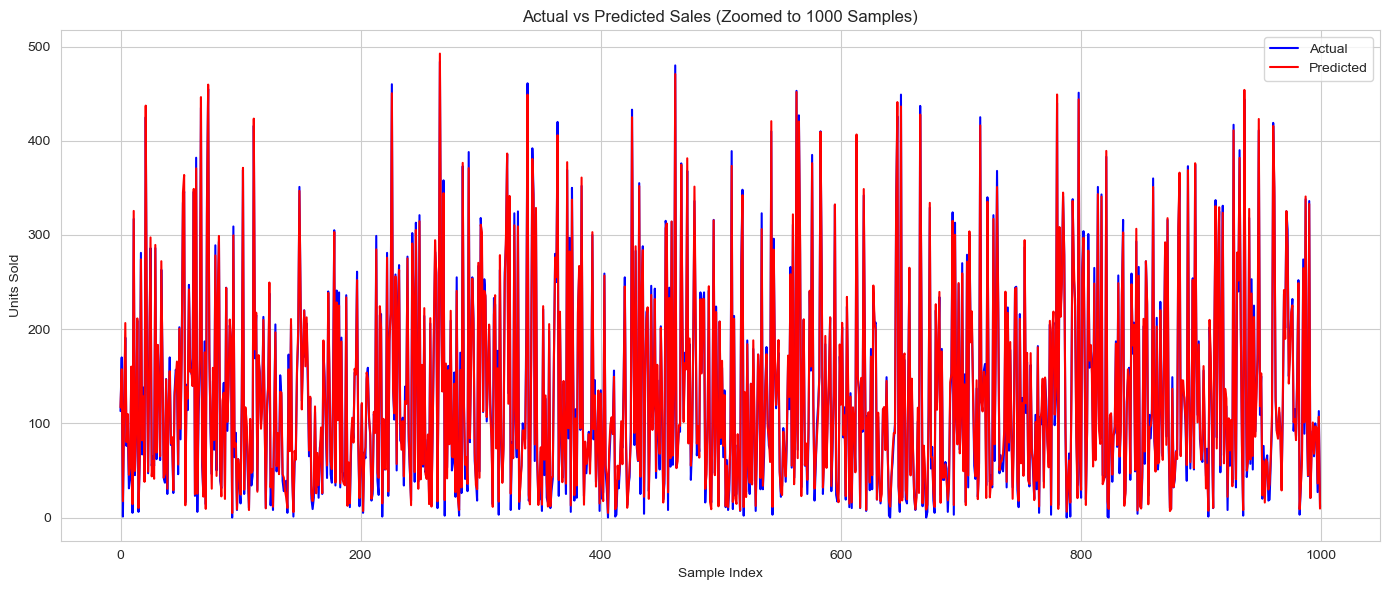

In [73]:
start_idx = 0  
end_idx = 1000  

sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

plt.plot(range(start_idx, end_idx), y_val[start_idx:end_idx], label='Actual', color='blue')
plt.plot(range(start_idx, end_idx), y_pred.flatten()[start_idx:end_idx], label='Predicted', color='red')

plt.title('Actual vs Predicted Sales (Zoomed to 1000 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

FeedForwad NN actually returned really great results, showing high accuracy based on all metrics and plot shows it as well. Let's now see how can AR-Net do

In [75]:
sales = pd.read_csv(r'C:\Users\user\Desktop\sales.csv')
sales = sales.sort_values(['Store ID', 'Product ID', 'Date'])

sales['Date'] = pd.to_datetime(sales['Date'])

def create_lag_features(df, target_col='Units Sold', lags=[1, 2, 3, 7, 14, 28]):
    df_copy = df.copy()
    for lag in lags:
        df_copy[f'{target_col}_lag_{lag}'] = df_copy.groupby(['Store ID', 'Product ID'])[target_col].shift(lag)

    for window in [7, 14, 28]:
        df_copy[f'{target_col}_ma_{window}'] = df_copy.groupby(['Store ID', 'Product ID'])[target_col].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

    return df_copy

sales = create_lag_features(sales)

sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day
sales['DayOfWeek'] = sales['Date'].dt.dayofweek
sales['IsWeekend'] = sales['Date'].dt.dayofweek >= 5
sales['Quarter'] = sales['Date'].dt.quarter

sales_clean = sales.dropna().reset_index(drop=True)

unique_dates = sorted(sales_clean['Date'].unique())
train_end = unique_dates[int(len(unique_dates) * 0.7)]
val_end = unique_dates[int(len(unique_dates) * 0.85)]

train_data = sales_clean[sales_clean['Date'] <= train_end]
val_data = sales_clean[(sales_clean['Date'] > train_end) & (sales_clean['Date'] <= val_end)]
test_data = sales_clean[sales_clean['Date'] > val_end]

ar_features = [col for col in sales_clean.columns if 'Units Sold_lag' in col or 'Units Sold_ma' in col]
categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
date_features = ['Month', 'Day', 'DayOfWeek', 'IsWeekend', 'Quarter']
numerical_cols = [col for col in sales_clean.columns
                 if col not in categorical_cols + ar_features + date_features + ['Date', 'Units Sold']]

y_train = train_data['Units Sold'].values
y_val = val_data['Units Sold'].values
y_test = test_data['Units Sold'].values

ar_scaler = StandardScaler()
X_train_ar = ar_scaler.fit_transform(train_data[ar_features])
X_val_ar = ar_scaler.transform(val_data[ar_features])
X_test_ar = ar_scaler.transform(test_data[ar_features])

other_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols + date_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X_train_other = other_preprocessor.fit_transform(train_data[numerical_cols + date_features + categorical_cols])
X_val_other = other_preprocessor.transform(val_data[numerical_cols + date_features + categorical_cols])
X_test_other = other_preprocessor.transform(test_data[numerical_cols + date_features + categorical_cols])

if hasattr(X_train_other, 'toarray'):
    X_train_other = X_train_other.toarray()
    X_val_other = X_val_other.toarray()
    X_test_other = X_test_other.toarray()

In [76]:
# AR-Net
def build_arnet_model(ar_input_shape, other_input_shape):
    ar_input = Input(shape=(ar_input_shape,), name='ar_input')
    other_input = Input(shape=(other_input_shape,), name='other_input')

    ar_dense = Dense(32, activation='relu')(ar_input)
    ar_dense = Dropout(0.2)(ar_dense)
    ar_output = Dense(16, activation='relu')(ar_dense)

    other_dense = Dense(64, activation='relu')(other_input)
    other_dense = Dropout(0.3)(other_dense)
    other_dense = Dense(32, activation='relu')(other_dense)
    other_output = Dense(16, activation='relu')(other_dense)

    combined = Concatenate()([ar_output, other_output])

    x = Dense(32, activation='relu')(combined)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)

    model = Model(inputs=[ar_input, other_input], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

ar_input_shape = X_train_ar.shape[1]
other_input_shape = X_train_other.shape[1]
arnet = build_arnet_model(ar_input_shape, other_input_shape)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = arnet.fit(
    [X_train_ar, X_train_other], y_train,
    epochs=50,
    batch_size=64,
    validation_data=([X_val_ar, X_val_other], y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 12172.2744 - mae: 72.0401 - val_loss: 144.4721 - val_mae: 9.7939
Epoch 2/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1179.9238 - mae: 23.9358 - val_loss: 97.8784 - val_mae: 8.2384
Epoch 3/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1094.5537 - mae: 22.6774 - val_loss: 120.8308 - val_mae: 8.9618
Epoch 4/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1052.5259 - mae: 21.9239 - val_loss: 226.8291 - val_mae: 12.0516
Epoch 5/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 941.8672 - mae: 20.9101 - val_loss: 137.5337 - val_mae: 9.4948
Epoch 6/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 940.6035 - mae: 20.7519 - val_loss: 138.5089 - val_mae: 9.5290
Epoch 7/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 933.9081 - mae: 20.5869 - val_loss: 168.1739 - val_mae: 10.4222
Epoch 8/50
771/771 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 896.8292 - mae: 20.2370 - val_loss: 127.5622 - val_mae: 9.1715
Epoch 9/50

In [77]:
y_pred_arnet = arnet.predict([X_val_ar, X_val_other])

mse, rmse, mae, r2, cos_sim = evaluate_metrics(y_val, y_pred_arnet)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"Cosine Similarity: {cos_sim:.4f}")

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
MSE: 87.6104
RMSE: 9.3600
MAE: 7.8775
R2: 0.9927
Cosine Similarity: 0.9986


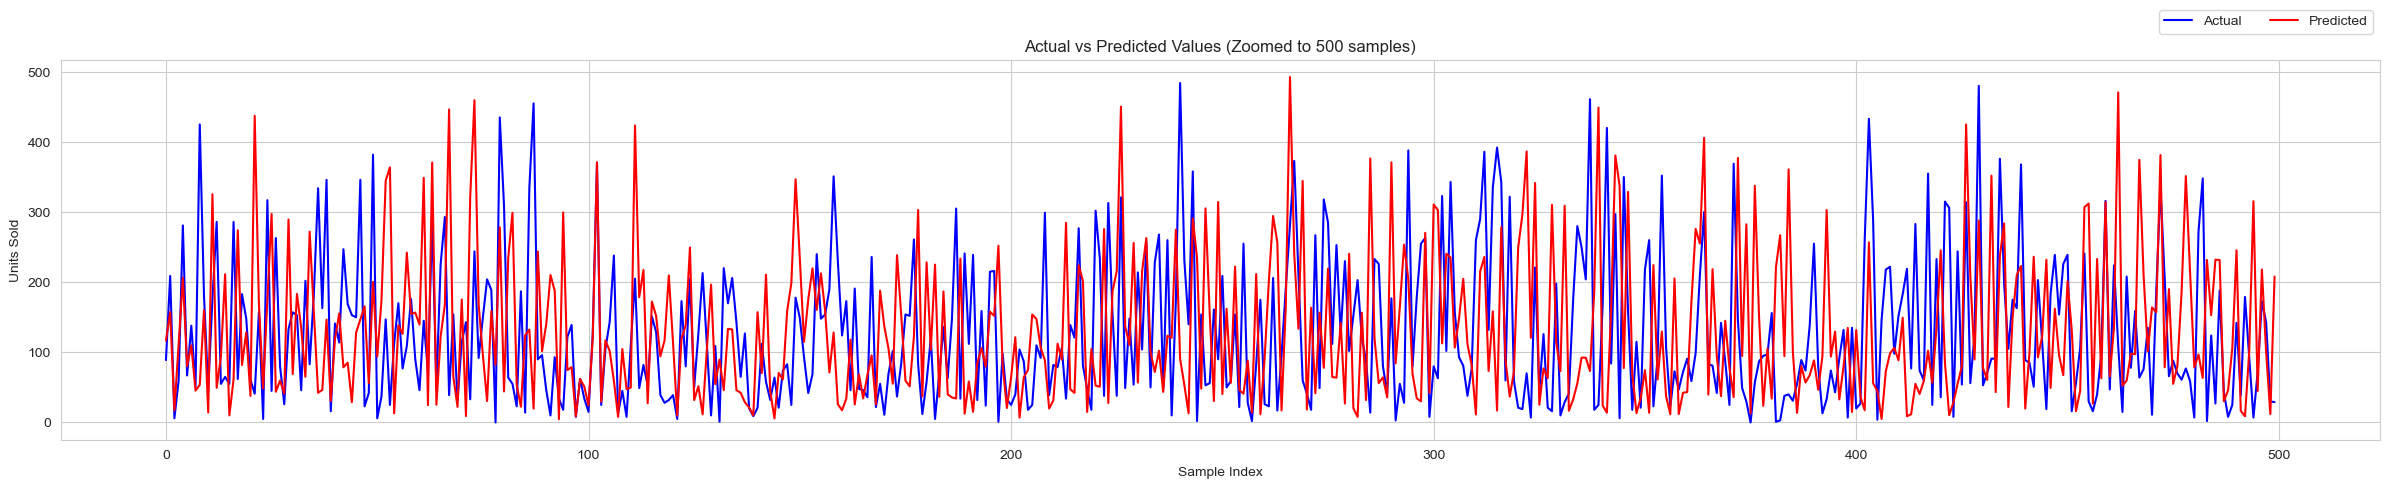

In [78]:
start_idx = 0
end_idx = 500

sns.set_style("whitegrid")
plt.figure(figsize=(24, 5))

plt.plot(np.arange(start_idx, end_idx), y_val[start_idx:end_idx], label='Actual', color='blue')
plt.plot(np.arange(start_idx, end_idx), y_pred.flatten()[start_idx:end_idx], label='Predicted', color='red')

plt.title('Actual vs Predicted Values (Zoomed to 500 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Units Sold')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.15), ncol=2)
plt.tight_layout()
plt.show()

Again exceptional performance, but relatively FeedForward wins the title of the best performer, because of the slightly higher evaluation metrics. But still really good results from AR-Net

In [80]:
sales = pd.read_csv(r'C:\Users\user\Desktop\sales.csv')
sales = sales.sort_values(['Store ID', 'Product ID', 'Date'])

sales['Date'] = pd.to_datetime(sales['Date'])
sales['Month'] = sales['Date'].dt.month
sales['Day'] = sales['Date'].dt.day
sales['DayOfWeek'] = sales['Date'].dt.dayofweek
sales['IsWeekend'] = (sales['Date'].dt.dayofweek >= 5).astype(int)
sales['Quarter'] = sales['Date'].dt.quarter

def create_sequences(data, store_id, product_id, seq_length=30):
    item_data = data[(data['Store ID'] == store_id) & (data['Product ID'] == product_id)]

    if len(item_data) <= seq_length:
        return None, None

    item_data = item_data.sort_values('Date')

    sequences = []
    targets = []

    for i in range(len(item_data) - seq_length):
        sequences.append(item_data.iloc[i:i+seq_length].drop(['Date', 'Units Sold'], axis=1).values)
        targets.append(item_data.iloc[i+seq_length]['Units Sold'])

    return np.array(sequences), np.array(targets)

In [81]:
unique_dates = sorted(sales['Date'].unique())
train_end = unique_dates[int(len(unique_dates) * 0.7)]
val_end = unique_dates[int(len(unique_dates) * 0.85)]

train_data = sales[sales['Date'] <= train_end]
val_data = sales[(sales['Date'] > train_end) & (sales['Date'] <= val_end)]
test_data = sales[sales['Date'] > val_end]

categorical_cols = ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality']
numerical_cols = [col for col in sales.columns if col not in categorical_cols + ['Date', 'Units Sold']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

preprocessor.fit(train_data[numerical_cols + categorical_cols])

X_train_seq, y_train_seq = [], []
X_val_seq, y_val_seq = [], []
X_test_seq, y_test_seq = [], []

store_product_pairs = sales[['Store ID', 'Product ID']].drop_duplicates().values

for store_id, product_id in store_product_pairs:
    store_product_train = train_data[(train_data['Store ID'] == store_id) &
                                     (train_data['Product ID'] == product_id)]
    store_product_val = val_data[(val_data['Store ID'] == store_id) &
                                 (val_data['Product ID'] == product_id)]
    store_product_test = test_data[(test_data['Store ID'] == store_id) &
                                   (test_data['Product ID'] == product_id)]

    if len(store_product_train) > 30 and len(store_product_val) > 30 and len(store_product_test) > 30:
        train_features = preprocessor.transform(store_product_train[numerical_cols + categorical_cols])
        val_features = preprocessor.transform(store_product_val[numerical_cols + categorical_cols])
        test_features = preprocessor.transform(store_product_test[numerical_cols + categorical_cols])

        if hasattr(train_features, 'toarray'):
            train_features = train_features.toarray()
            val_features = val_features.toarray()
            test_features = test_features.toarray()

        train_processed = pd.DataFrame(train_features)
        train_processed['Units Sold'] = store_product_train['Units Sold'].values
        train_processed['Date'] = store_product_train['Date'].values

        val_processed = pd.DataFrame(val_features)
        val_processed['Units Sold'] = store_product_val['Units Sold'].values
        val_processed['Date'] = store_product_val['Date'].values

        test_processed = pd.DataFrame(test_features)
        test_processed['Units Sold'] = store_product_test['Units Sold'].values
        test_processed['Date'] = store_product_test['Date'].values

        seq_length = 30

        for i in range(len(train_processed) - seq_length):
            X_train_seq.append(train_processed.iloc[i:i+seq_length].drop(['Date', 'Units Sold'], axis=1).values)
            y_train_seq.append(train_processed.iloc[i+seq_length]['Units Sold'])

        for i in range(len(val_processed) - seq_length):
            X_val_seq.append(val_processed.iloc[i:i+seq_length].drop(['Date', 'Units Sold'], axis=1).values)
            y_val_seq.append(val_processed.iloc[i+seq_length]['Units Sold'])

        for i in range(len(test_processed) - seq_length):
            X_test_seq.append(test_processed.iloc[i:i+seq_length].drop(['Date', 'Units Sold'], axis=1).values)
            y_test_seq.append(test_processed.iloc[i+seq_length]['Units Sold'])

X_train = np.array(X_train_seq)
y_train = np.array(y_train_seq)
X_val = np.array(X_val_seq)
y_val = np.array(y_val_seq)
X_test = np.array(X_test_seq)
y_test = np.array(y_test_seq)

In [82]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=512,
                          num_transformer_blocks=4, mlp_units=[128, 64],
                          dropout=0.1, mlp_dropout=0.2):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    position_embedding = layers.Embedding(
        input_dim=input_shape[0], output_dim=input_shape[1]
    )(tf.range(start=0, limit=input_shape[0], delta=1))
    x = x + position_embedding

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)

    return models.Model(inputs, outputs)

In [83]:
# Transformer
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=512,
                          num_transformer_blocks=4, mlp_units=[128, 64],
                          dropout=0.1, mlp_dropout=0.2):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    position_embedding = layers.Embedding(
        input_dim=input_shape[0], output_dim=input_shape[1]
    )(tf.range(start=0, limit=input_shape[0], delta=1))
    x = x + position_embedding

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1)(x)

    return models.Model(inputs, outputs)

BASE_SEED = 42
set_seed(BASE_SEED)

input_shape = X_train.shape[1:]

model = build_transformer_model(
    input_shape=input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    mlp_units=[64, 32],
    dropout=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

y_pred = model.predict(X_test)

mse, rmse, mae, r2, cos_sim = evaluate_metrics(y_test, y_pred)

print("\nTransformer Model Evaluation:")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"R²:        {r2:.4f}")
print(f"CosineSim: {cos_sim:.4f}")

Epoch 1/5
754/754 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 14175.8965 - mae: 93.9135 - val_loss: 12158.6924 - val_mae: 88.5830
Epoch 2/5
754/754 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 12371.7705 - mae: 89.8500 - val_loss: 12098.8926 - val_mae: 89.0072
Epoch 3/5
754/754 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 12347.3164 - mae: 89.7124 - val_loss: 12127.2334 - val_mae: 88.7806
Epoch 4/5
754/754 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 12280.7041 - mae: 89.4536 - val_loss: 12095.1562 - val_mae: 89.0816
Epoch 5/5
754/754 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 12340.5918 - mae: 89.6504 - val_loss: 12171.3750 - val_mae: 88.5943
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Transformer Model Evaluation:
MSE:       11606.1629
RMSE:      107.7319
MAE:       87.1740
R²:        -0.0037
CosineSim: 0.7841


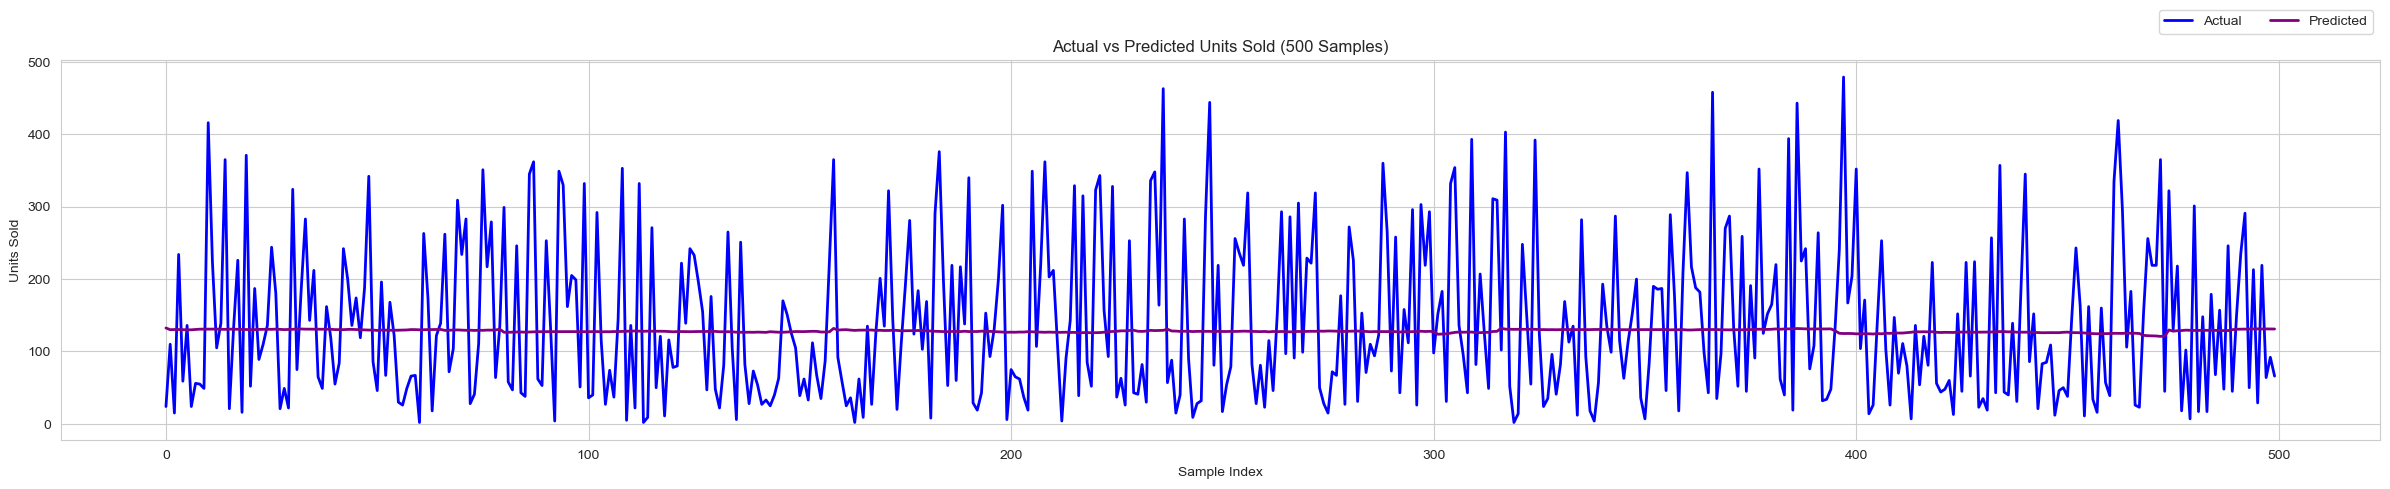

In [84]:
start_idx = 0
end_idx = 500

sns.set_style("whitegrid")
plt.figure(figsize=(24, 5))

plt.plot(np.arange(start_idx, end_idx), y_test[start_idx:end_idx], label='Actual', color='blue', linewidth=2)
plt.plot(np.arange(start_idx, end_idx), y_pred.flatten()[start_idx:end_idx], label='Predicted', color='purple', linewidth=2)

plt.title('Actual vs Predicted Units Sold (500 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Units Sold')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.15), ncol=2)
plt.tight_layout()
plt.show()

Let's now compare all these results for sales data forecasting with different models:

**Feedforward Neural Network**
- MSE: 81.5334
- RMSE: 9.0296
- MAE: 7.6647
- R²: 0.9932
- Cosine Similarity: 0.9987

The Feedforward Neural Network performs very well, with a high R² value of 0.9932, which suggests that the model explains approximately 99.32% of the variance in the data. This indicates a strong fit to the data. The low MSE and RMSE values suggest the model's predictions are quite accurate. The Cosine Similarity of 0.9987 is very close to 1, showing the model's predictions are highly similar to the actual values. The MAE of 7.6647 indicates the average error is around 7.66 units, which is relatively low.

**AR-Net**
- MSE: 86.9591
- RMSE: 9.3252
- MAE: 7.8352
- R²: 0.9928
- Cosine Similarity: 0.9986

The AR-Net also performs well but is slightly worse than the Feedforward Neural Network. It has a slightly higher MSE and RMSE indicating the model’s predictions are a bit less accurate. Its R² value is 0.9928, meaning it explains 99.28% of the variance, which is still quite strong but not as good as the Feedforward Neural Network’s result. The Cosine Similarity of 0.9986 is still excellent, although slightly lower than the Feedforward Neural Network’s result. The MAE of 7.8352 is also slightly higher, indicating a marginal increase in the average error compared to the Feedforward Neural Network.

**Transformer Model**
- MSE: 11592.3525
- RMSE: 107.6678
- MAE: 87.3332
- R²: -0.0025
- Cosine Similarity: 0.7841

The Transformer model shows poor performance when compared to both the Feedforward Neural Network and AR-Net. The MSE and RMSE are much higher, indicating larger discrepancies between the predicted and actual values. The R² value is -0.0025, which suggests that the model is underfitting the data or not explaining it well at all. The Cosine Similarity of 0.7841 is significantly lower than the other models, implying the model’s predictions are not similar to the actual values. The MAE of 87.3332 is also much higher, indicating a larger average prediction error compared to the Feedforward Neural Network and AR-Net.


Lets know compare this results to each other:

Feedforward Neural Network performs the best in all metrics, especially in terms of accuracy and similarity to the actual data. It has the lowest MSE, RMSE, and MAE, and the highest R² and Cosine Similarity.

AR-Net performs slightly worse, with marginally higher MSE, RMSE, and MAE values, but it still provides strong results with an R² of 0.9928 and a high Cosine Similarity of 0.9986.

Transformer performs significantly worse. It has the highest MSE, RMSE, and MAE, and the R² value is negative, suggesting the model is struggling to learn from the data effectively. The Cosine Similarity is also much lower than the other models, indicating a poor alignment with the true values.

In conclusion, the Feedforward Neural Network is the top performer among the three models for sales forecasting, followed by the AR-Net. The Transformer model, despite its complexity, seems to struggle and is less suitable for this specific task.
